<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

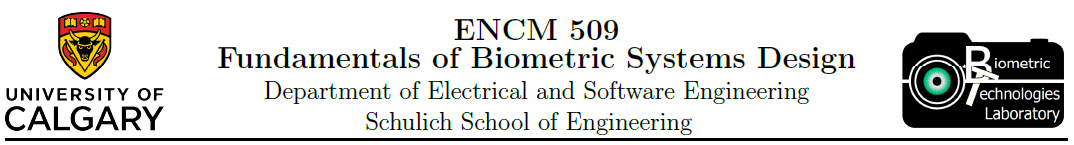

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
    <h3>Youssef Abdel Maksoud, 30062891</h3>
</center>

# Introduction

The purpose of this lab exercise is to process images using enhancement, and feature extraction as well as becoming familier with classifications models used in face recognition. Images are placed into a gallery, then processed. Principal component analysis is used for feature extraction using different amounts of principal components before using a KNN classification model. The images are placed into training and test sets. Classification is also performed by calculating the euclidean distances of a probe against images in the gallery. Confusion matrices are used to analyse the differences in models when model parameters such as the number of nearest neighbours are tweaked.

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Exercise 1

In [539]:
#For the gallery we will use subjects 8, 9, and 10
#subject 8 path
path_eight = "./ATT dataset/s8/"
#subject 9 path
path_nine = "./ATT dataset/s9/"
#subject 10 path
path_ten = "./ATT dataset/s10/"
#subject 11 path
path_eleven = "./ATT dataset/s1/"
#subject 12 path
path_twelve = "./ATT dataset/s2/"

#number of images in the training set
M = 27

#image normalization
um = 100
ustd = 80

In [540]:
# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path_eight + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

Size of each image: (112, 92) 10304


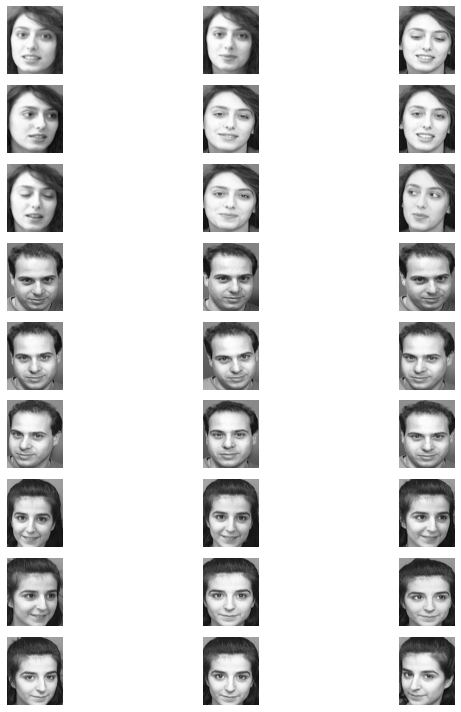

In [541]:
plt.figure(figsize=(10,10))
for i in range(1,M+1):
    if i < 10:
        img = imread(path_eight + '{}.pgm'.format(i), as_gray=True)
    elif i < 19 and i >= 10:
        img = imread(path_nine + '{}.pgm'.format(i-9), as_gray=True)
    else:
        img = imread(path_ten + '{}.pgm'.format(i-18), as_gray=True)
    
    plt.subplot(9,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

In [542]:
# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

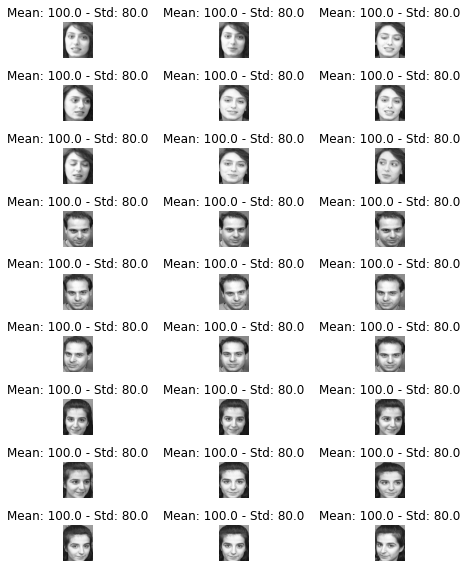

In [543]:
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(9,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

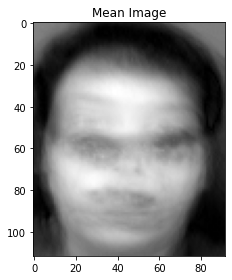

In [544]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

In [545]:
#Covariance matrix
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

In [546]:
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

<ipython-input-546-99f1d61e62f7>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


In [547]:
#eigenvector normalization
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

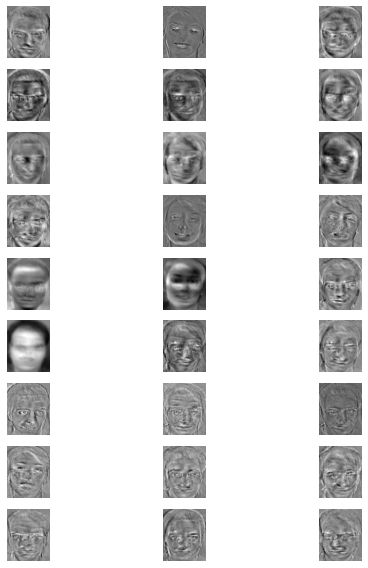

In [548]:
#eigenfaces
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(9,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [549]:
#finding the weight of each face
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

#### 10th Image Probes

In [550]:
KnownImage1 = imread(path_eight + '10.pgm', as_gray=True)
KnownImage2 = imread(path_nine + '10.pgm', as_gray=True)
KnownImage3 = imread(path_ten + '10.pgm', as_gray=True)

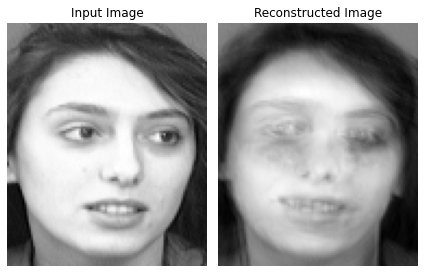

In [551]:
# image processing 1

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(KnownImage1, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage1 = np.reshape(KnownImage1, (irow*icol,1))

# Normalization
temp1 = InImage1
me1 = np.mean(temp1)
st1 = np.std(temp1)
temp1 = (temp1-me1) * ustd/st1 + um
NormImage1 = temp1

# Finding Difference: NormalizedImage - MeanImage
Difference1 = temp1 - m

p1 = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare1 = np.dot(u[:,i], NormImage1) 
    p1[i] = pare1

# m is the mean image, u is the eigenvector
ReshapedImage1 = m + np.matmul(u, p1) 
ReshapedImage1 = np.reshape(ReshapedImage1, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage1, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight1 = np.zeros((M,1))

for i in range(u.shape[1]):
    t1 = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage1 = np.dot(t1, Difference1) 
    InImWeight1[i] = WeightOfInputImage1

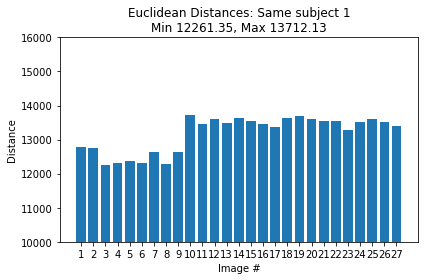

In [552]:
#euclidean distance
eSameSubject1 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight1 = InImWeight1 - q
    mag1 = np.linalg.norm(DiffWeight1)
    eSameSubject1[i] = mag1

# max/min Euclidean distance
MaximumValue1 = np.max(eSameSubject1) 
MinimumValue1 = np.min(eSameSubject1) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27')

plt.bar(np.arange(len(eSameSubject1)), eSameSubject1.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject 1\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue1, MaximumValue1));

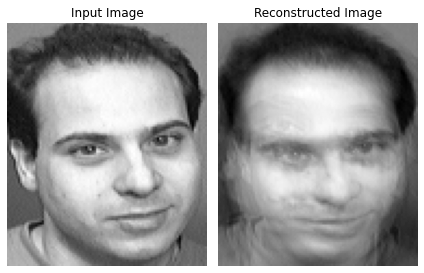

In [553]:
plt.subplot(1,2,1)
plt.imshow(KnownImage2, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage2 = np.reshape(KnownImage2, (irow*icol,1))

# Normalization
temp2 = InImage2
me2 = np.mean(temp2)
st2 = np.std(temp2)
temp2 = (temp2-me2) * ustd/st2 + um
NormImage2 = temp2

# Finding Difference: NormalizedImage - MeanImage
Difference2 = temp2 - m

p2 = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare2 = np.dot(u[:,i], NormImage2) 
    p2[i] = pare2

# m is the mean image, u is the eigenvector
ReshapedImage2 = m + np.matmul(u, p2) 
ReshapedImage2 = np.reshape(ReshapedImage2, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage2, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight2 = np.zeros((M,1))

for i in range(u.shape[1]):
    t2 = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage2 = np.dot(t2, Difference2) 
    InImWeight2[i] = WeightOfInputImage2

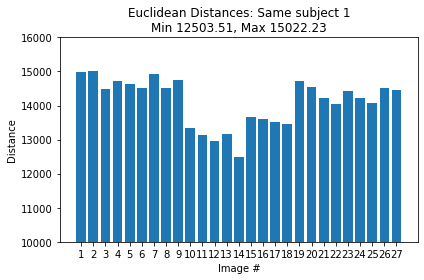

In [554]:
#euclidean distance
eSameSubject2 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight2 = InImWeight2 - q
    mag = np.linalg.norm(DiffWeight2)
    eSameSubject2[i] = mag

# max/min Euclidean distance
MaximumValue2 = np.max(eSameSubject2) 
MinimumValue2 = np.min(eSameSubject2) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27')

plt.bar(np.arange(len(eSameSubject2)), eSameSubject2.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject 1\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue2, MaximumValue2));

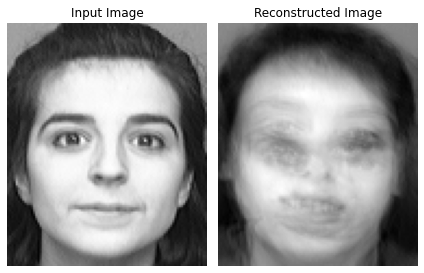

In [555]:
plt.subplot(1,2,1)
plt.imshow(KnownImage3, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage3 = np.reshape(KnownImage3, (irow*icol,1))

# Normalization
temp3 = InImage3
me3 = np.mean(temp3)
st3 = np.std(temp3)
temp3 = (temp3-me3) * ustd/st3 + um
NormImage3 = temp3

# Finding Difference: NormalizedImage - MeanImage
Difference3 = temp3 - m

p3 = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare3 = np.dot(u[:,i], NormImage3) 
    p3[i] = pare3

# m is the mean image, u is the eigenvector
ReshapedImage3 = m + np.matmul(u, p3) 
ReshapedImage3 = np.reshape(ReshapedImage3, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage3, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight3 = np.zeros((M,1))

for i in range(u.shape[1]):
    t3 = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage3 = np.dot(t3, Difference3) 
    InImWeight3[i] = WeightOfInputImage3

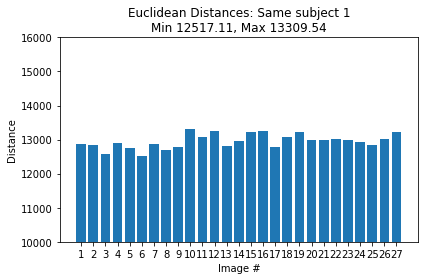

In [556]:
#euclidean distance
eSameSubject3 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight3 = InImWeight3 - q
    mag3 = np.linalg.norm(DiffWeight3)
    eSameSubject3[i] = mag3

# max/min Euclidean distance
MaximumValue3 = np.max(eSameSubject3) 
MinimumValue3 = np.min(eSameSubject3) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27')

plt.bar(np.arange(len(eSameSubject3)), eSameSubject3.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject 1\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue3, MaximumValue3));

#### Unknown Face Probes

In [557]:
UnknownImage1 = imread(path_eleven + '10.pgm', as_gray=True)
UnknownImage2 = imread(path_twelve + '10.pgm', as_gray=True)

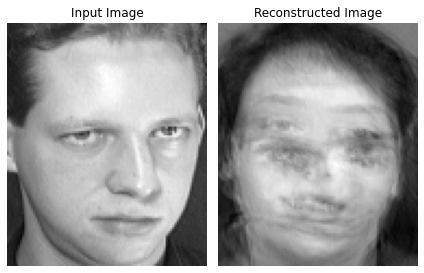

In [558]:
plt.subplot(1,2,1)
plt.imshow(UnknownImage1, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage4 = np.reshape(UnknownImage1, (irow*icol,1))

# Normalization
temp4 = InImage4
me = np.mean(temp4)
st = np.std(temp4)
temp4 = (temp4-me) * ustd/st + um
NormImage4 = temp4

# Finding Difference: NormalizedImage - MeanImage
Difference4 = temp4 - m

p4 = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage4) 
    p4[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage4 = m + np.matmul(u, p4) 
ReshapedImage4 = np.reshape(ReshapedImage4, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage4, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight4 = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage4 = np.dot(t, Difference4) 
    InImWeight4[i] = WeightOfInputImage4

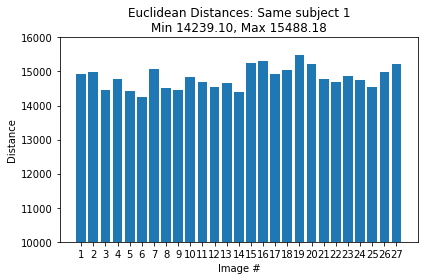

In [559]:
#euclidean distance
eDiffSubject4 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight4 = InImWeight4 - q
    mag = np.linalg.norm(DiffWeight4)
    eDiffSubject4[i] = mag

# max/min Euclidean distance
MaximumValue4 = np.max(eDiffSubject4) 
MinimumValue4 = np.min(eDiffSubject4) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27')

plt.bar(np.arange(len(eDiffSubject4)), eDiffSubject4.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject 1\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue4, MaximumValue4));

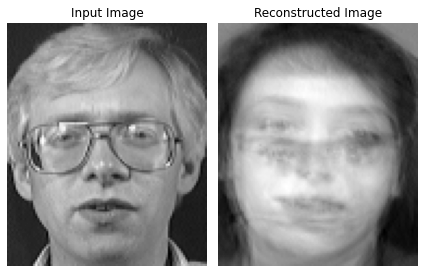

In [560]:
plt.subplot(1,2,1)
plt.imshow(UnknownImage2, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage5 = np.reshape(UnknownImage2, (irow*icol,1))

# Normalization
temp5 = InImage5
me = np.mean(temp5)
st = np.std(temp5)
temp5 = (temp5-me) * ustd/st + um
NormImage5 = temp5

# Finding Difference: NormalizedImage - MeanImage
Difference5 = temp5 - m

p5 = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage5) 
    p5[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage5 = m + np.matmul(u, p5) 
ReshapedImage5 = np.reshape(ReshapedImage5, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage5, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight5 = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage5 = np.dot(t, Difference5) 
    InImWeight5[i] = WeightOfInputImage5

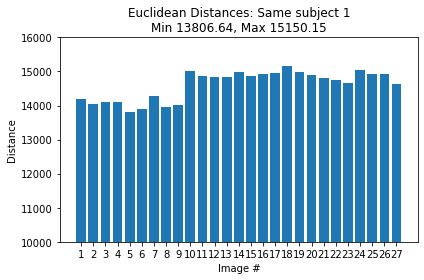

In [561]:
#euclidean distance
eDiffSubject5 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight5 = InImWeight5 - q
    mag = np.linalg.norm(DiffWeight5)
    eDiffSubject5[i] = mag

# max/min Euclidean distance
MaximumValue5 = np.max(eDiffSubject5) 
MinimumValue5 = np.min(eDiffSubject5) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27')

plt.bar(np.arange(len(eDiffSubject5)), eDiffSubject5.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject 1\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue5, MaximumValue5));

#### Not-A-Face Probe

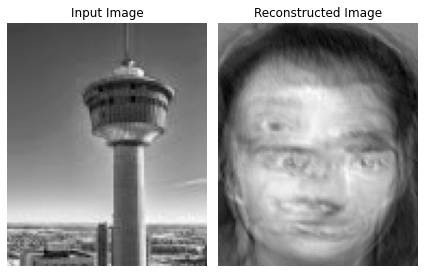

In [562]:
# using the first face ('1.pgm') from subject 20
path = './'
InputImage = imread(path + 'CalgaryTower.jpg', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

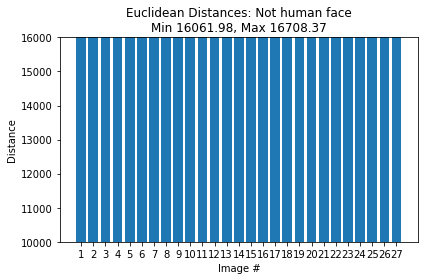

In [563]:
eTower = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eTower) 
MinimumValue = np.min(eTower) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27')
plt.bar(np.arange(len(eTower)), eTower.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));

# Exercise 2

In [578]:
def match(subject):
    # Set Threshold Values 
    threshold1 = 15080
    threshold2 = 15500

    distances = subject
    #distances = eDiffSubject
    #distances = eTower


    mean_of_distances = np.mean(distances);
    print(np.max(subject), np.min(subject), mean_of_distances)
    if (np.max(subject) <= threshold1):
        print('Image is in the database')
    elif (np.max(subject) > threshold1 and np.max(subject) <= threshold2):
        print('Image is a face but not in the database')
    elif (mean_of_distances > threshold2):
        print('Image is not a face')

In [579]:
print("KnownImage1")
match(eSameSubject1)
print("KnownImage2")
match(eSameSubject2)
print("KnownImage3")
match(eSameSubject3)
print("UnknownImage1")
match(eDiffSubject4)
print("UnknownImage2")
match(eDiffSubject5)
print("Calgary Tower")
match(eTower)

KnownImage1
13712.134944235286 12261.348495885539 13184.415191411998
Image is in the database
KnownImage2
15022.22642255449 12503.514268828032 14116.435926930126
Image is in the database
KnownImage3
13309.540436474306 12517.111724744627 12955.604887892092
Image is in the database
UnknownImage1
15488.175158642664 14239.104636142461 14817.076627268829
Image is a face but not in the database
UnknownImage2
15150.14639661774 13806.638920726096 14609.661437220175
Image is a face but not in the database
Calgary Tower
16708.367707420257 16061.984836831554 16424.342252046885
Image is not a face


# Exercise 3

In [642]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

#### 50 Principal Components

In [643]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


In [644]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [645]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 200
Size of each sample: 10304


In [646]:
# n_components: number of principal components
n_components_pca = 50
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [647]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

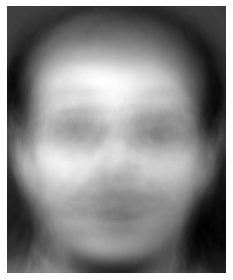

In [648]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

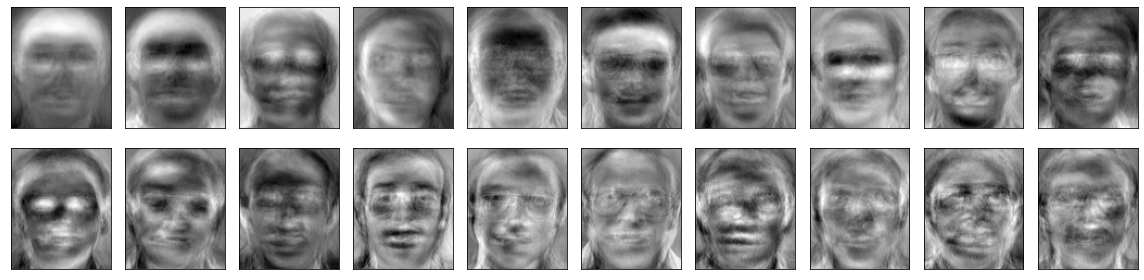

In [649]:
fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [650]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 85%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


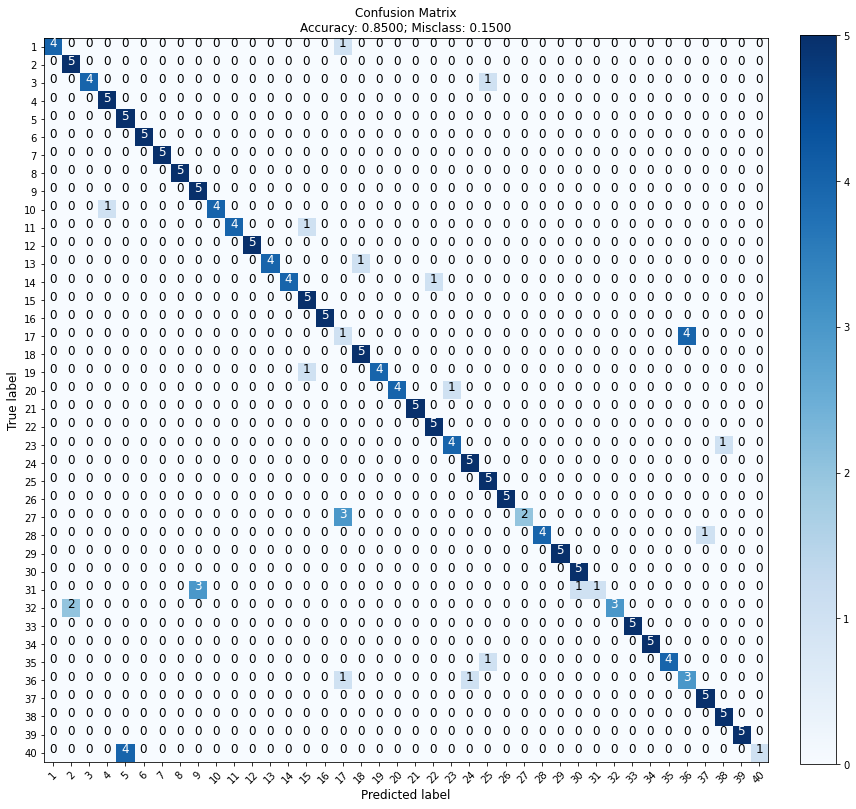

In [651]:
# Generate the confusion matrix
confusionMatrix1 = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix1,
                      target_names = [i for i in range(1, n_subjects+1)])

#### 100 Principal Components

In [652]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


In [653]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [654]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 200
Size of each sample: 10304


In [655]:
# n_components: number of principal components
n_components_pca = 50
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [656]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

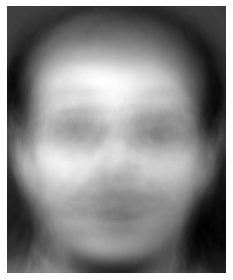

In [657]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

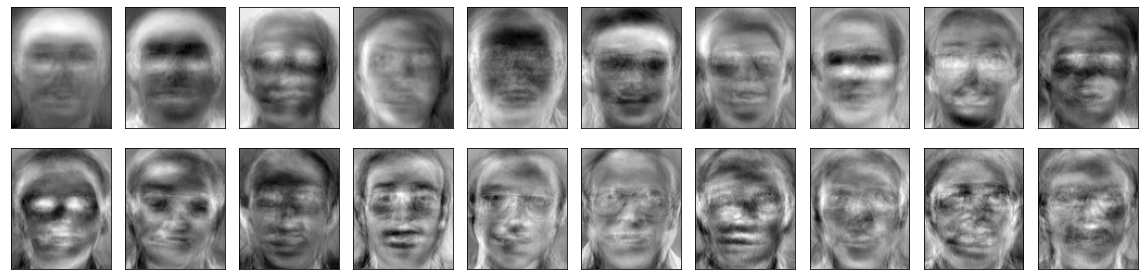

In [658]:
fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [659]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 84%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


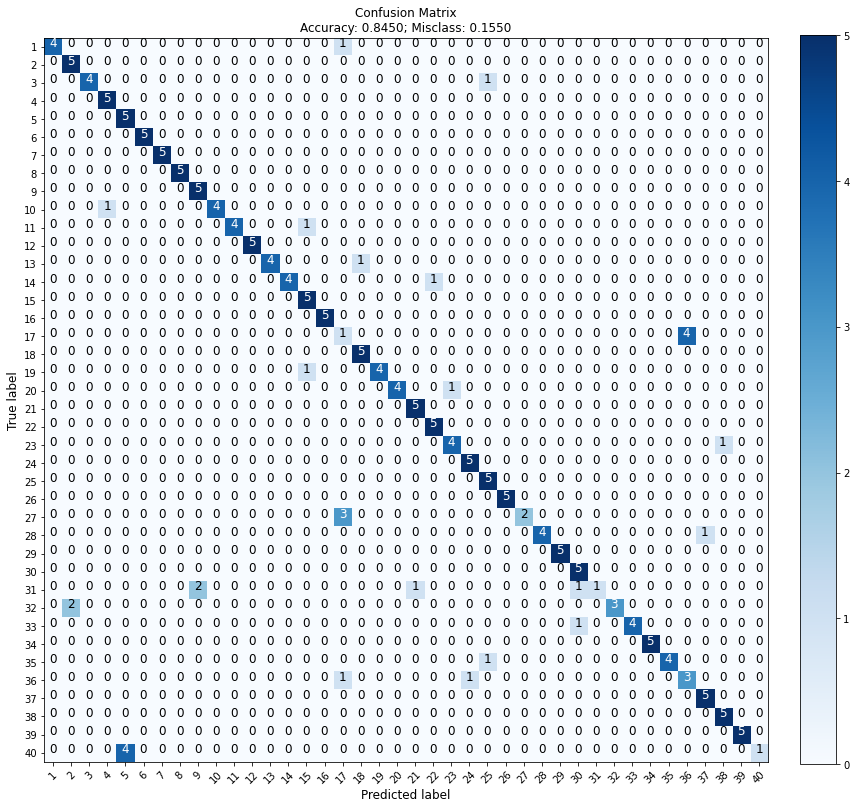

In [660]:
# Generate the confusion matrix
confusionMatrix2 = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix2,
                      target_names = [i for i in range(1, n_subjects+1)])

#### 200 Principal Components

In [661]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


In [662]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [663]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 200
Size of each sample: 10304


In [664]:
# n_components: number of principal components
n_components_pca = 200
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [665]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

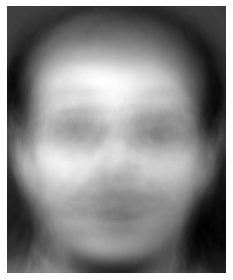

In [666]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

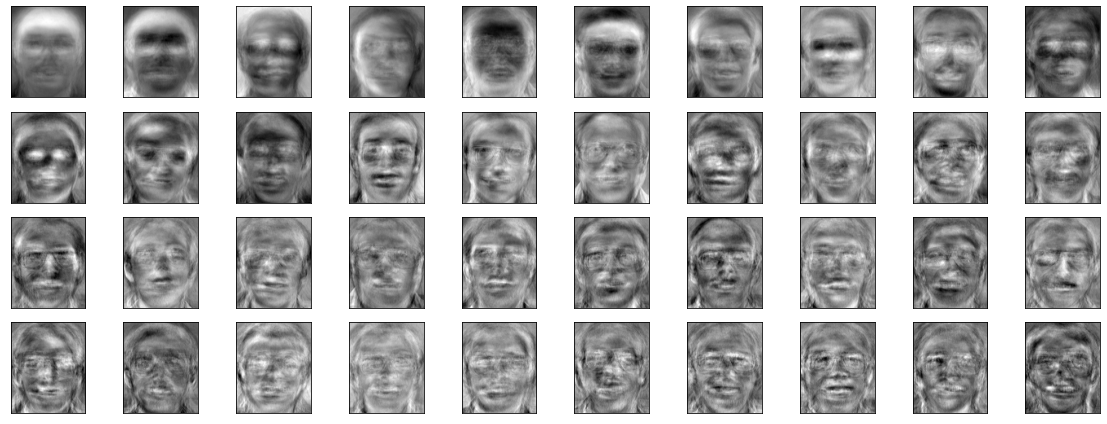

In [667]:
fig = plt.figure(figsize=(16, 6))
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [668]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


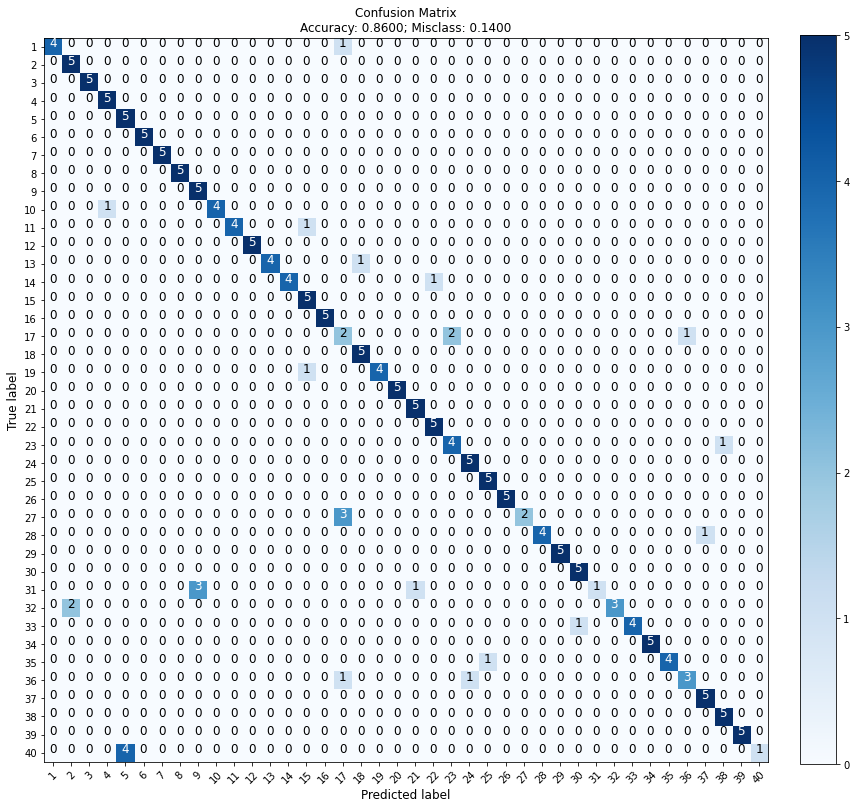

In [669]:
# Generate the confusion matrix
confusionMatrix3 = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix3,
                      target_names = [i for i in range(1, n_subjects+1)])

In [670]:
X = []
diag50 = []
diag100 = []
diag200 = []

for i in range(40):
    diag50.append(confusionMatrix1[i][i])
    diag100.append(confusionMatrix2[i][i])
    diag200.append(confusionMatrix3[i][i])
    X.append(i+1)
    

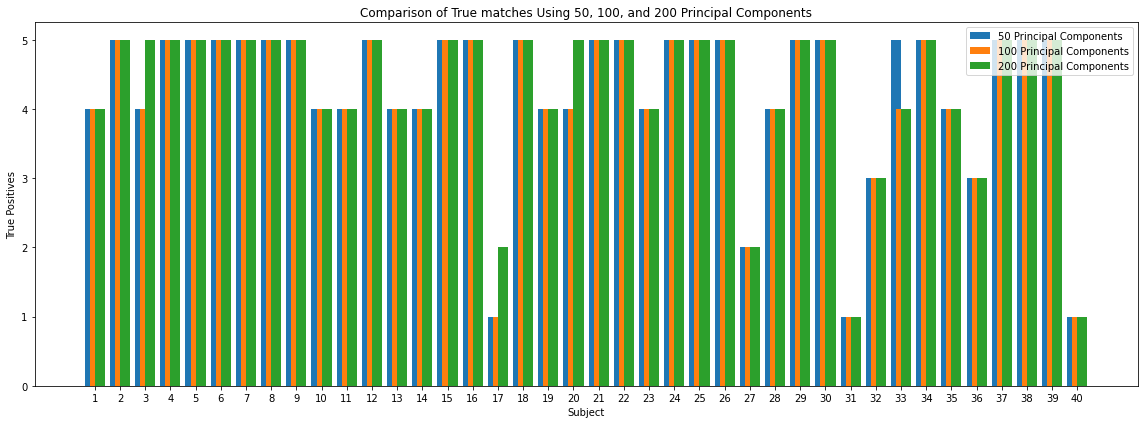

In [671]:
X_axis = np.arange(len(X))

plt.figure(figsize=(16, 6))
plt.bar(X_axis - 0.2, diag50, 0.4, label = '50 Principal Components')
plt.bar(X_axis, diag100, 0.4, label = '100 Principal Components')
plt.bar(X_axis + 0.2, diag200, 0.4, label = '200 Principal Components')

plt.xticks(X_axis, X)
plt.xlabel('Subject')
plt.ylabel('True Positives')
plt.title('Comparison of True matches Using 50, 100, and 200 Principal Components')
plt.legend()
plt.show()

Observed differences in correct classification occured on subjects 3, 17, 20, and 33. Subject 3 was incorrectly classified as subject 25 when using 50, and 100 principal components. Subject 17 was misclassified 1 less time when using 200 principal components. Using 50, and 100 principal components, subject 20 was misclassified as subject 23. Subject 33 was misclassified as subject 30 when using 100 and 200 principal components. The accuracies when using 50, 100, and 200 principal components are 85%, 84.5% and 86% respectively.

# Exercise 4

### 5 Neighbours

In [674]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 8
n_test_images = 2

knn_neighbors = 5

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]


In [675]:
# use the first 8 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 2 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [676]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 160
Size of each sample: 10304


In [677]:
# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [678]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

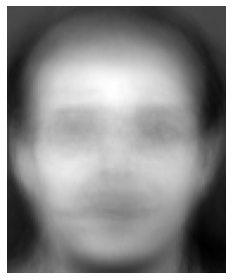

In [679]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

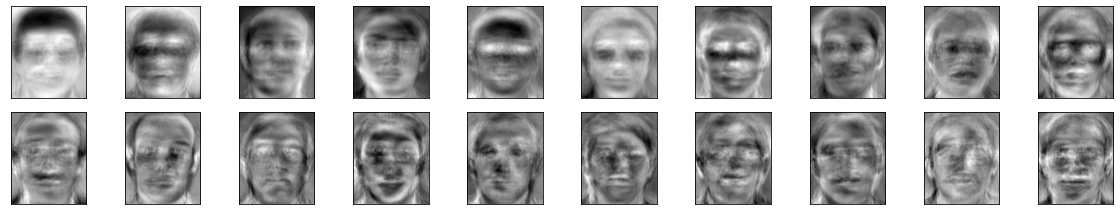

In [680]:
fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [681]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 92%
Subject #1:
	TP: 2, FP: 0, TN: 38, FN: 0
	TPR: 100.00%, TNR: 100.00%, FPR: 0.00%, FNR: 0.00%


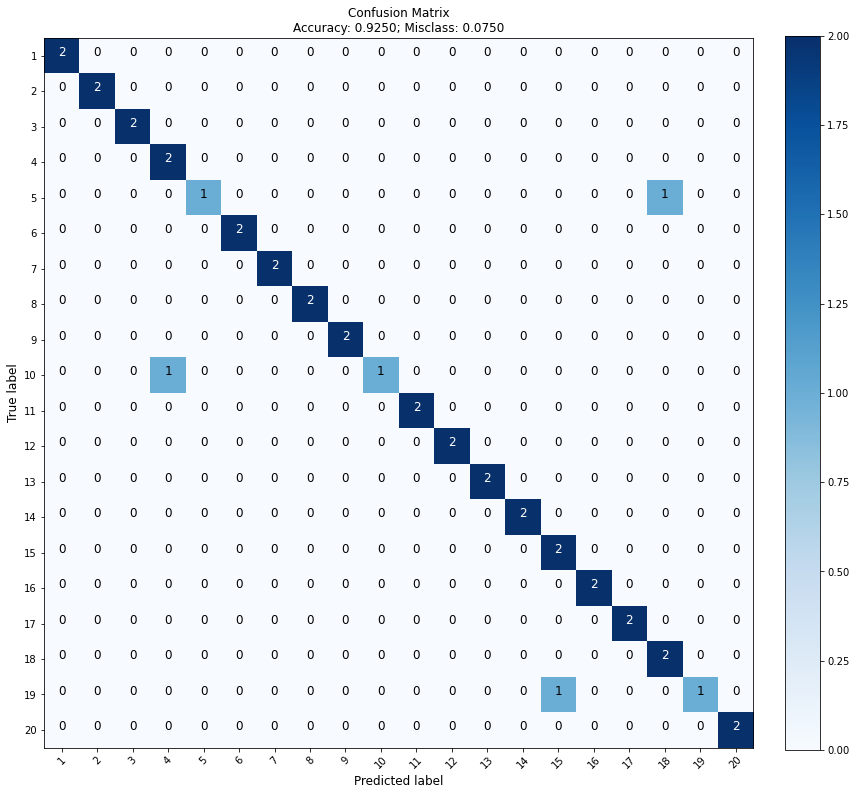

In [683]:
# Generate the confusion matrix
confusionMatrix4 = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix4,
                      target_names = [i for i in range(1, n_subjects+1)])

### 11 Neighbours

In [684]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 8
n_test_images = 2

knn_neighbors = 11

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 20 subjects:
	8 images will be used for TRAINING: [1, 2, 3, 4, 5, 6, 7, 8]
	2 images will be used for TEST: [9, 10]


In [685]:
# use the first 8 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 2 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

In [686]:
print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 160
Size of each sample: 10304


In [687]:
# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces);

In [688]:
train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

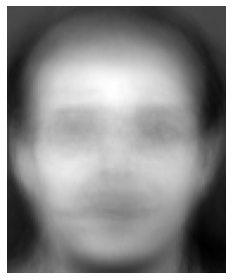

In [689]:
plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off');

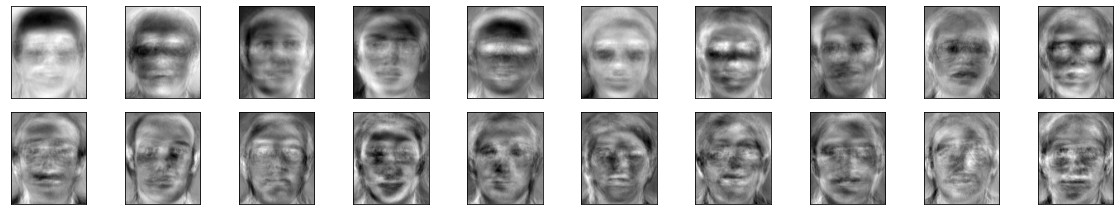

In [690]:
fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

In [691]:
knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

Overall Accuracy: 77%
Subject #1:
	TP: 1, FP: 0, TN: 38, FN: 1
	TPR: 50.00%, TNR: 100.00%, FPR: 0.00%, FNR: 50.00%


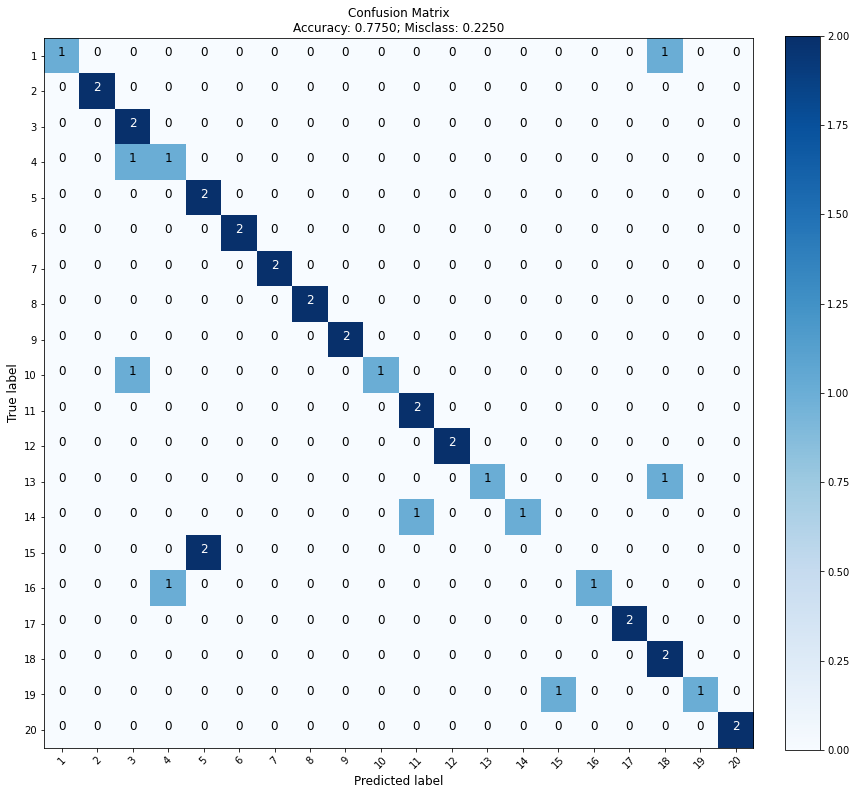

In [692]:
# Generate the confusion matrix
confusionMatrix5 = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix5,
                      target_names = [i for i in range(1, n_subjects+1)])

In [693]:
X = []
diag5 = []
diag11 = []

for i in range(20):
    diag5.append(confusionMatrix4[i][i])
    diag11.append(confusionMatrix5[i][i])
    X.append(i+1)
    

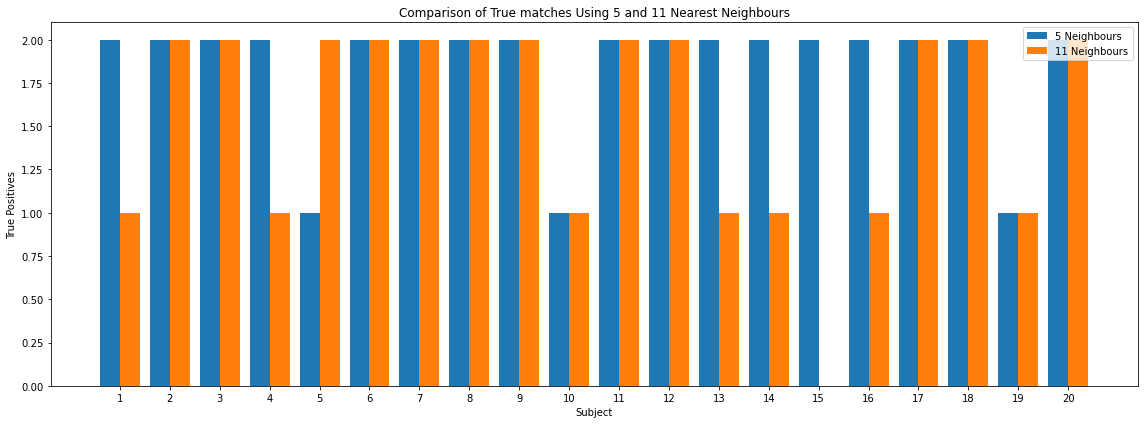

In [695]:
X_axis = np.arange(len(X))

plt.figure(figsize=(16, 6))
plt.bar(X_axis - 0.2, diag5, 0.4, label = '5 Neighbours')
plt.bar(X_axis + 0.2, diag11, 0.4, label = '11 Neighbours')

plt.xticks(X_axis, X)
plt.xlabel('Subject')
plt.ylabel('True Positives')
plt.title('Comparison of True matches Using 5 and 11 Nearest Neighbours')
plt.legend()
plt.show()

Using 5 and 11 Neighbours yielded accuracies of 92% and 77% respectively. There were 3 misclassifications when using 5 neighbours while there were 9 misclassifications when using 11 neighbours. However, since there were less images in the testing set (2 images) increasing the number of test images may increase the yield of using 11 neighbours.

# Conclusion

It is evident that there are many ways to tweak a model. It is possible to adjust not only model parameters, but parameters of the image processing methods. Changing the number of principal components, and the number of nearest neighbours affects the performance of the model. Changing the train-test set ratio also yields different results. Alternalive to KNN, it is possible to classify images by calculating the euclidean distance between a probe and a template image. Thresholds are then chosen to distinguish a match from a non match.